In [15]:
import sys
import os

import sqlite3

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import hex2color
import seaborn as sns

sys.path.append(os.environ['OC_PATH'] + '01-Projets/conf')

from conf import ci_var, palette, conf_graph

In [16]:
database = 'data/database.sqlite'
conn = sqlite3.connect(database)

tables=pd.read_sql(""" SELECT * FROM sqlite_master WHERE type='table';""",conn)
#tables

In [17]:
df_matchs = pd.read_sql(""" SELECT * FROM Match """,conn)
df_teams = pd.read_sql(""" SELECT * FROM Team """,conn)

In [18]:
df_matchs['date'] = pd.to_datetime(df_matchs['date'])

df_matchs = pd.merge(
    df_matchs,
    df_teams[['team_api_id', 'team_long_name']].add_prefix('home_'),
    on='home_team_api_id'
)

df_matchs = pd.merge(
    df_matchs,
    df_teams[['team_api_id', 'team_long_name']].add_prefix('away_'),
    on='away_team_api_id'
)

df = df_matchs.loc[
    (df_matchs['home_team_long_name'].str.contains('Lyon'))
    | (df_matchs['away_team_long_name'].str.contains('Lyon'))
].copy()

df = df.loc[~pd.isna(df['B365H'])]
df = df.reset_index(drop=True)

In [19]:
def ol_won(match):
    if (((match['home_team_long_name'] == 'Olympique Lyonnais')
        and (match['home_team_goal'] > match['away_team_goal']))
        or ((match['home_team_long_name'] != 'Olympique Lyonnais')
        and (match['home_team_goal'] < match['away_team_goal'])) ):
        return 1
    else:
        return 0

df['ol_won'] = df.apply(lambda match: ol_won(match), axis=1)

In [20]:
def ol_favorite(match):
    if (((match['home_team_long_name'] == 'Olympique Lyonnais')
        and (match['B365H'] < match['B365A']))
        or ((match['home_team_long_name'] != 'Olympique Lyonnais')
        and (match['B365H'] > match['B365A'])) ):
        return 1
    else:
        return 0

df['ol_favorite'] = df.apply(lambda match: ol_favorite(match), axis=1)

In [21]:
def blind_bet(match):
    if match['home_team_long_name'] == 'Olympique Lyonnais':
        if (match['ol_won'] == 1) and (match['ol_won'] == match['ol_favorite']):
            return match['B365H']
        elif (match['ol_won'] == 0) and (match['ol_won'] == match['ol_favorite']):
            return match['B365A']
    elif match['home_team_long_name'] != 'Olympique Lyonnais':
        if (match['ol_won'] == 1) and (match['ol_won'] == match['ol_favorite']):
            return match['B365A']
        elif (match['ol_won'] == 0) and (match['ol_won'] == match['ol_favorite']):
            return match['B365H']
    return 0

df['blind_bet'] = df.apply(lambda match: blind_bet(match), axis=1)

In [22]:
df[['date', 'home_team_long_name', 'away_team_long_name',
    'home_team_goal', 'away_team_goal',
    'B365H', 'B365D', 'B365A',
    'ol_won', 'ol_favorite',
   'blind_bet']].iloc[:50]

,date,home_team_long_name,away_team_long_name,home_team_goal,away_team_goal,B365H,B365D,B365A,ol_won,ol_favorite,blind_bet
0,2009-05-12,Olympique Lyonnais,FC Nantes,3,0,1.30,5.00,10.00,1,1,1.30
1,2013-09-22,Olympique Lyonnais,FC Nantes,3,1,1.75,3.40,5.00,1,1,1.75
2,2015-02-22,Olympique Lyonnais,FC Nantes,1,0,1.57,3.80,6.50,1,1,1.57
3,2016-03-19,Olympique Lyonnais,FC Nantes,2,0,1.62,3.75,6.00,1,1,1.62
4,2008-10-25,AJ Auxerre,Olympique Lyonnais,0,0,4.20,3.30,1.91,0,1,0.00
5,2009-08-22,AJ Auxerre,Olympique Lyonnais,0,3,4.00,3.20,2.00,1,1,2.00
6,2011-05-11,AJ Auxerre,Olympique Lyonnais,4,0,3.40,3.20,2.20,0,1,0.00
7,2011-11-27,AJ Auxerre,Olympique Lyonnais,0,3,3.10,3.10,2.40,1,1,2.40
8,2009-04-19,Girondins de Bordeaux,Olympique Lyonnais,1,0,2.60,3.00,2.88,0,0,2.60
9,2010-04-17,Girondins de Bordeaux,Olympique Lyonnais,2,2,2.15,3.20,3.50,0,0,2.15


In [23]:
df = df.sort_values('date')

In [24]:
df['smooth_oods'] = df['blind_bet'].rolling(window=20, min_periods=1).mean()

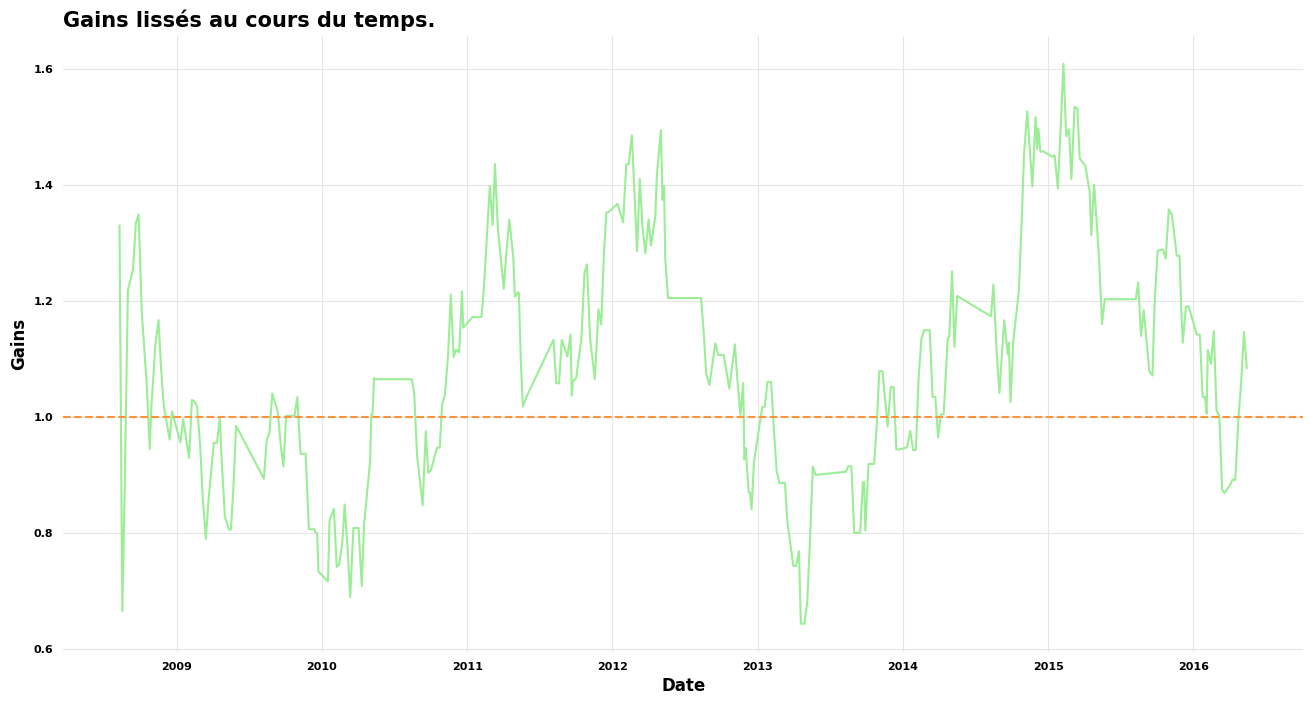

In [27]:
plt.figure(figsize=(16, 8))

# Plot.
sns.lineplot(
    x="date", y="smooth_oods", data=df, color=palette[2]
)

plt.axhline(y=1, color=palette[3], linestyle='--', label='Reference Line (y=1)')

# Titres et labels.
plt.title("Gains lissés au cours du temps.", **conf_graph["title_style"])
plt.xlabel("Date", **conf_graph["label_style"])
plt.ylabel("Gains", **conf_graph["label_style"])
plt.xticks(**conf_graph["tick_style"])
plt.yticks(**conf_graph["tick_style"])
#plt.show()

plt.savefig('gains_lisses.png', dpi=720)